The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25
Run:  50
Run:  75
Delta:  2.4999999999999996
Run:  0
Run:  25


Text(0.5, 0, 'Noise level')

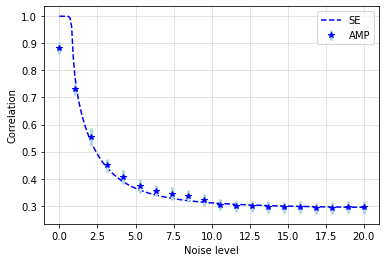

In [98]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

@author: järvi raes
"""
%load_ext autoreload
%autoreload 2

import numpy as np
import tikzplotlib
import matplotlib.pyplot as plt
from ipynb.fs.full.amp_qgt import sub_amp_bayes, amp_bayes, create_beta, Xiid_to_Xtilde, y_iid_to_y_iid_tilde, g_in_bayes, deriv_g_in_bayes, mmse_new
from ipynb.fs.full.se_qgt import state_ev_iid_disc, state_ev_iid_disc_sub
from numpy.random import binomial
import math
from numba import jit
import numpy as np
from scipy.integrate import quad


def sub_amp_bayesN(X, X_T, y, t, nu, beta_0, theta, delta, noisey):
    m, n = len(X), len(X[0])
    tau_array = []
    error_norm_array = []
    nc_array = []
    
    tau_2 = noisey**2+(p**(1-theta)/delta)*nu
    #tau_2 = 100
    #Initialise x
    beta = np.ones(n)*nu   
    for iter_no in range(t):
        #print(iter_no)
        if iter_no==0:
            #Initialise x, z and tau
            z = y - np.dot(X, beta)
            tau_prev = 0
        else:
            Onsager = (1/m) * z * np.sum(deriv_g_in_bayes(betaXz, tau_2, nu))
            z             = y - np.dot(X,beta) + Onsager
            tau_prev = np.copy(tau)

        #Estimate noise variance tau from residual z
        #tau_2  = (np.linalg.norm(z, ord=2)**2)/ m
        tau_2 = ((noisey**2+ n**(1-theta)/delta)*mmse_new(np.sqrt(tau_2), nu)+1e-10)
        #print(tau_2)
        
        betaXz = np.dot(X_T, z) + beta
        beta     = g_in_bayes(betaXz, tau_2, nu)

        beta = np.nan_to_num(beta) #Avoid nan
    
        tau = np.sqrt(tau_2)
        tau_array.append(tau)
        
        #Compute performance metrics
        mse = (1/n)*(np.linalg.norm(beta - beta_0)**2)
        norm_correl = (np.dot(beta, beta_0)/(np.linalg.norm(beta)*np.linalg.norm(beta_0)))**2

        error_norm_array.append(mse)
        nc_array.append(norm_correl)
        
        #Stopping criterion - Relative norm tolerance
        if (tau - tau_prev)**2/tau_2 < 1e-9:
            break
        
        tau_prev = tau
        
    mse_pred = delta*(tau_2)

    return beta, mse_pred, tau_array, error_norm_array, nc_array
'''=== Compute pdf of a Gaussian ==='''
@jit(nopython=True)
def norm_pdf(x, loc=0, scale=1):
    return np.exp(-((x-loc)/scale)**2/2)/(np.sqrt(2*np.pi)*scale)

'''=== Compute Bayes-optimal denoiser in terms of snr s ==='''
@jit(nopython=True)
def cond_exp_s(arg, s_sqrt, nu):
    denomin = nu*norm_pdf(arg - s_sqrt) + (1 - nu)*norm_pdf(arg)
    
    frac = (1/denomin)*(nu*norm_pdf(arg - s_sqrt))
    #print(norm_pdf(arg - s_sqrt), norm_pdf(arg),frac)
    return frac

@jit(nopython=True)
def mmse_integrand(y, s_sqrt, nu):
    f_y = nu*norm_pdf(y, s_sqrt, 1) + (1-nu)*norm_pdf(y)
    integ = f_y*(cond_exp_s(y, s_sqrt,nu)**2)
    #print(integ)
    return integ

'''=== Compute MSE of Bayes-optimal denoiser by integrating ==='''
def mmse_new(s_sqrt, nu):
    if s_sqrt < 25:
        integral = quad(mmse_integrand, -30, 30, args=(s_sqrt,nu))[0]
        #print(quad(mmse_integrand, -30, 30, args=(s_sqrt,nu)))
        mmse = nu - integral
        #print(mmse)
    elif nu < 1:
        integral = quad(mmse_integrand, -10, 10, args =(s_sqrt, nu))[0] + \
        quad(mmse_integrand, s_sqrt - 5, s_sqrt + 5, args =(s_sqrt, nu))[0]
        mmse = nu - integral
    else:
        integral = quad(mmse_integrand, s_sqrt - 5, s_sqrt + 5, args =(s_sqrt, nu))[0]
        mmse = nu - integral
    return mmse

#----------------Figure 6a------------------------------------------------------
theta = 0.8
#number of subjects
p = 500
# defective chance

run_no = 100



noise_array = np.linspace(0.00, 20, num=20)
#print(noise_array)
se_noise_array = np.linspace(0.00, 20, num=200)

nc_array_av = []
nc_array_std = []
se_nc_array = []


for noisey in noise_array:
    #theoretical information limit
    ITL = 2*(1-theta)/theta*p**theta
    #defective chance
    nu = p**(theta-1)
    #noisey = 0
    #delta
    delta = 5*ITL/(nu*p)
    print("Delta: ", delta)
    #number of tests
    n = np.round(delta*nu*p).astype(int)
    #print(ITL, n)
    
    mse_runs = []
    nc_runs = []
    
    #IID
    for run in range(run_no):
        beta_0 = create_beta(nu, p)
        
        #print(beta_noisy)
        t = 100
        #chance of inclusion in a test
        alpha = 0.5
        if(run % 25 ==0):
            print("Run: ", run)
            
        X = binomial(1, alpha, (n,p))
        y = np.dot(X, beta_0)
        noise_vector = np.random.normal(0,1,len(y))*noisey
        #y = y + noise_vector
        #print(y)
        #AMP
        X_tilde = Xiid_to_Xtilde(X, alpha)
        
        defect_no = np.sum(beta_0)
        
        y_tilde = y_iid_to_y_iid_tilde(y, alpha, nu, n, p, defect_no)
        y_tilde = y_tilde+noise_vector/np.sqrt(n*alpha*(1-alpha))
        #y_tilde = y_tilde+noise_vector
        X_tilde_T = np.transpose(X_tilde)
        beta, mse_pred, tau_array, error_norm_array, nc_array = sub_amp_bayesN(X_tilde, X_tilde_T, y_tilde, t, nu, beta_0, theta, delta, noisey)
        norm_correl = (np.dot(beta, beta_0)/(np.linalg.norm(beta)*np.linalg.norm(beta_0)))**2
        
        nc_runs.append(norm_correl)
        

    nc_array_av.append(np.average(nc_runs))
    nc_array_std.append(np.std(nc_runs))
    
    
    
   
    
    

for noisey in se_noise_array:  
    noisey = noisey
    noisey=noisey/np.sqrt(n*alpha*(1-alpha))
    #noisey=noisey
    #print(delta, t, nu, p, theta)
    #IID STATE EVOLUTION
    sigma2 = ((noisey**2)*p**(1-theta)/(delta*alpha*(1-alpha)))
    #print(sigma2)
    tau2 = sigma2+nu*p**(1-theta)/delta
    tau = np.sqrt(tau2)
    tau_array = []
    for _ in range(t):
        tau_array.append(tau)
        tau_prev = tau

        #1e-10 added here to avoid sqrt of neg. value 
        theta2 = (p**(1-theta)/delta)*mmse_new(1/tau, nu)+1e-10
        
        tau2 = sigma2+theta2
        tau = np.sqrt(tau2)
        #print(tau)
        
        #Stopping criteria
        if tau < 1e-50:
            break
        
        if (tau - tau_prev)**2/tau**2 < 1e-12:
            break 
    #print(nu, tau, p**(1-theta),p**(theta-1), delta/(p**(1-theta)), delta/(p**(1-theta))*(tau**2))   
    mse_pred =   delta/p**(1-theta)*(tau**2-sigma2)
    #print(tau, tau**2)
    nc_pred = 1 - (mse_pred/nu)
    #print(nc_pred, mse_pred, nu)
    se_nc_array.append(nc_pred)
    
plt.figure()
plt.plot(se_noise_array, se_nc_array, label=r'SE', color = 'blue', linestyle = 'dashed')
plt.errorbar(noise_array, nc_array_av, yerr=nc_array_std, label =r"AMP", fmt='*', color='blue',ecolor='lightblue', elinewidth=3, capsize=0)
plt.grid(alpha=0.4)
plt.legend()
plt.ylabel('Correlation')
plt.xlabel('Noise level')
#tikzplotlib.save("pool_fig6a.tex")

